In [1]:
import random
import imutils

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

/tmp/ipykernel_25834/487897824.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-01-25 14:30:22.169466: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-25 14:30:22.169542: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-25 14:30:22.193097: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable t

In [2]:
tf.config.list_physical_devices('GPU')

2024-01-25 14:30:26.457013: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-25 14:30:26.550508: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-25 14:30:26.550800: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
let = cv2.imread('data/letterlist.jpg', 0)
let = let[15:780,:]
num_letters = 33
num_fonts = 21

In [4]:
type(let), let.shape

(numpy.ndarray, (765, 795))

In [5]:
let.shape[0]//33, let.shape[1]//33

(23, 24)

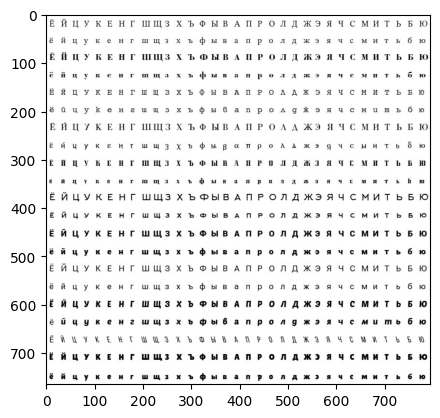

In [6]:
plt.imshow(let, cmap='gray')

(36, 24)


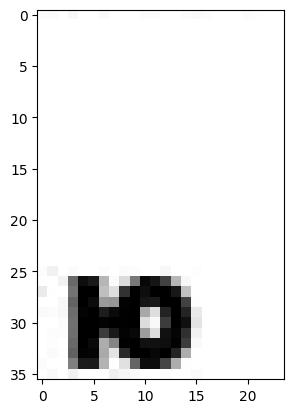

In [7]:
def get_letter(font_num, letter_num):
    return let[let.shape[0]//num_fonts*(font_num-1):let.shape[0]//num_fonts*font_num,
           let.shape[1]//num_letters*(letter_num-1):let.shape[1]//num_letters*letter_num,
           ]
test = get_letter(21,33)
print(test.shape)
plt.imshow(test, cmap='gray')

In [8]:
def get_letter_variants(letter_num):
        return let[:,
           let.shape[1]//num_letters*(letter_num-1):let.shape[1]//num_letters*letter_num,
           ]

def get_font_variants(font_num):
    return let[let.shape[0]//num_fonts*(font_num-1):let.shape[0]//num_fonts*font_num,
           :,
           ]

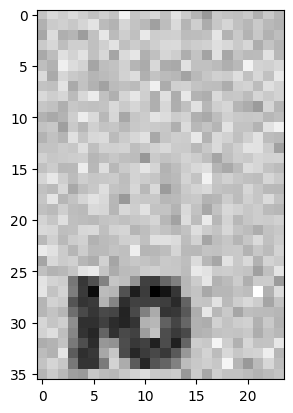

In [9]:
def apply_noise(letter, max=30):
    noise = np.random.normal(size=(letter.shape))*max
    return letter+noise
plt.imshow(apply_noise(test), cmap='gray')

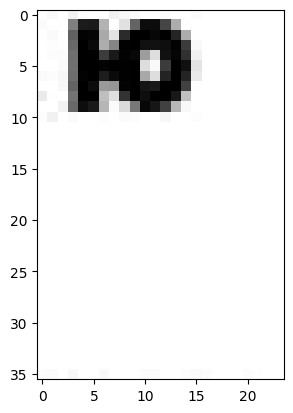

In [10]:
def flip(letter, mode='horizontal'):
    if mode == 'horizontal':
        return np.flip(letter, axis=0)
    elif mode == 'vertical':
        return np.flip(letter, axis=1)
    elif mode == 'random':
        axis = random.random() < 0.5
        return np.flip(letter, axis=int(axis))
plt.imshow(flip(test), cmap='gray')  

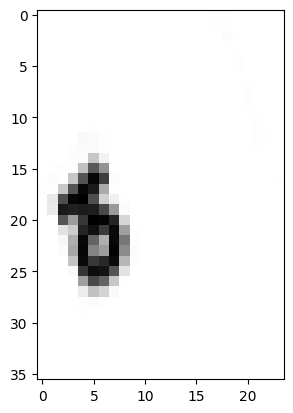

In [11]:
def rotate(letter, angle=60):
    image = np.zeros_like(letter) + 255 - letter
    rotated = imutils.rotate_bound(image, angle)
    rotated = np.zeros_like(rotated) + 255 - rotated
    rotated = cv2.resize(rotated, (letter.shape[1], letter.shape[0]))
    return rotated
rotated = rotate(test)
plt.imshow(rotated, cmap='gray')

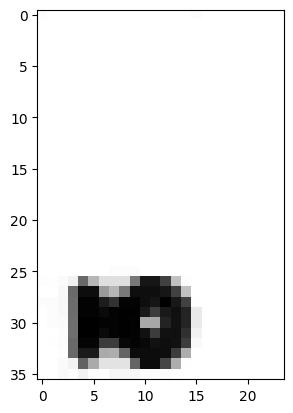

In [12]:
def blur(letter, kernel_size=3):
    return cv2.medianBlur(letter, kernel_size)
plt.imshow(blur(test), cmap='gray')

In [116]:
class Augmenter():
    NOISE_CHANCE = 0.8
    NOISE_HARDNESS = 15
    
    FLIP_CHANCE = 0.3
    
    ROTATE_CHANCE = 0.2
    
    BLUR_CHANCE = 0.4
    BLUR_HARD_CHANCE = 0.1
    
    images = []
    captions = []
    
    def __init__(self, images, captions):
        self.images_orig = images
        self.captions_orig = captions
    
    def apply_noise(self, letter):
        noise = np.random.normal(size=(letter.shape))*self.NOISE_HARDNESS
        return letter+noise
    
    def flip(self, letter, mode='horizontal'):
        if mode == 'horizontal':
            return np.flip(letter, axis=0)
        elif mode == 'vertical':
            return np.flip(letter, axis=1)
        elif mode == 'random':
            axis = random.random() < 0.5
            return np.flip(letter, axis=int(axis))
        
    def rotate(self, letter, angle=60):
        image = np.zeros_like(letter) + 255 - letter
        rotated = imutils.rotate_bound(image, angle)
        rotated = np.zeros_like(rotated) + 255 - rotated
        rotated = cv2.resize(rotated, (letter.shape[1], letter.shape[0]))
        return rotated
    
    def blur(self, letter, kernel_size=3):
        img = letter
        try:
            img =  cv2.medianBlur(img, kernel_size)
        except:
            pass
        return img
    
    def random_augment(self, rounds = 1, seed = 42, save_last=False):
        random.seed(seed)
        
        images = self.images_orig
        captions = self.captions_orig
        
        for _ in range(rounds):
            print(len(images))
            num_images = len(images)
            for n in range(num_images):
                image = images[n]
                if random.random() < self.NOISE_CHANCE:
                    images.append(self.apply_noise(image))
                    captions.append(captions[n])
                if random.random() < self.FLIP_CHANCE:
                    images.append(self.flip(image))
                    captions.append(captions[n])
                if random.random() < self.ROTATE_CHANCE:
                    images.append(self.rotate(image, random.randint(-5,5)))
                    captions.append(captions[n])
                if random.random() < self.BLUR_CHANCE:
                    images.append(self.blur(image))
                    captions.append(captions[n])
                if random.random() < self.BLUR_HARD_CHANCE:
                    images.append(self.blur(image, 5))
                    captions.append(captions[n])
            if save_last:
                images = images[num_images:]
                captions = captions[num_images:]
        self.images = images
        self.captions = captions

In [117]:
images = []
captions = []
captions_base = "Ё Й Ц У К Е Н Г Ш Щ З Х Ъ Ф Ы В А П Р О Л Д Ж Э Я Ч С М И Т Ь Б Ю".split(' ')
for i in range(1, num_fonts+1):
    for j in range(1, num_letters+1):
        images.append(get_letter(i,j))
        captions.append(captions_base[j-1])

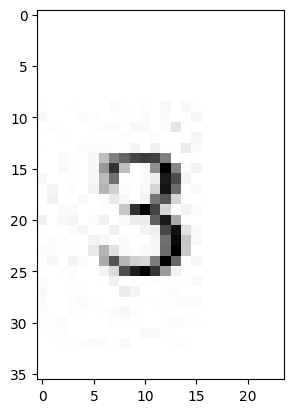

In [118]:
plt.imshow(images[10], cmap='gray')

In [119]:
len(images)

693

In [120]:
aug = Augmenter(images.copy(), captions.copy())

In [121]:
len(aug.images), len(images)

(0, 693)

In [122]:
aug.random_augment(5)

693
1905
5353
15007
42002


Х


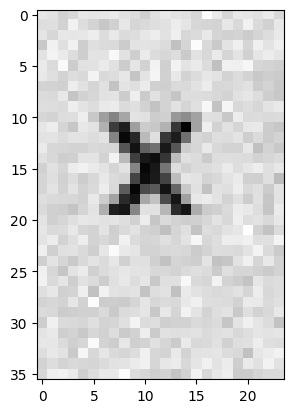

In [123]:
n = 10000
print(aug.captions[n])
plt.imshow(aug.images[n], cmap='gray')

In [124]:
np.array(aug.images).shape[1:]

(36, 24)

# Model

In [125]:
from tensorflow import keras

In [126]:
x_data = np.array(aug.images)
x_data = x_data.reshape(*x_data.shape, 1)
x_data.shape

(117573, 36, 24, 1)

In [127]:
classes = list(map(captions_base.index, aug.captions))
y_data = keras.utils.to_categorical(classes, num_classes=num_letters)

In [128]:
test_aug = Augmenter(images.copy(), captions.copy())
test_aug.random_augment(7, 65, True)
len(test_aug.images), len(test_aug.captions)

693
1252
2191
3982
7113
12690
22941


(41459, 41459)

In [129]:
test_x_data = np.array(test_aug.images)
test_x_data = test_x_data.reshape(*test_x_data.shape, 1)

test_classes = list(map(captions_base.index, test_aug.captions))
test_y_data = keras.utils.to_categorical(test_classes, num_classes=num_letters)

In [130]:
inputs = keras.layers.Input(shape=(*np.array(aug.images).shape[1:],1), name='inputs')
conv = keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(inputs)
conv = keras.layers.MaxPool2D()(conv)
conv = keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(conv)
conv = keras.layers.MaxPool2D()(conv)
# conv = keras.layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same')(conv)
# conv = keras.layers.MaxPool2D()(conv)
dense = keras.layers.Flatten()(conv)
dense = keras.layers.Dense(1024, activation='relu')(dense)
dense = keras.layers.Dense(512, activation='relu')(dense)
dense = keras.layers.Dense(256, activation='relu')(dense)
dense = keras.layers.Dense(num_letters, activation='softmax')(dense)

model = keras.models.Model(inputs=inputs, outputs=dense)
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 36, 24, 1)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 36, 24, 128)       1280      
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 18, 12, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 18, 12, 256)       295168    
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 9, 6, 256)         0         
 ng2D)                                                           
                                                                 
 flatten_6 (Flatten)         (None, 13824)             0   

In [131]:
model.compile(loss='categorical_crossentropy', metrics=['categorical_accuracy'], optimizer='adam')

In [132]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_delta = 1e-3,
                              patience=3, min_lr=1e-10)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=7)
tensorboard = keras.callbacks.TensorBoard(log_dir="./logs")

In [133]:
his = model.fit(x_data, y_data,
          epochs=50,
          batch_size=128,
          shuffle=True,
          validation_split=0.2,
          callbacks=[reduce_lr, early_stop, tensorboard],
                )

Epoch 1/50
735/735 [==============================] - 13s 17ms/step - loss: 1.4858 - categorical_accuracy: 0.7884 - val_loss: 0.2445 - val_categorical_accuracy: 0.9233 - lr: 0.0010
Epoch 2/50
735/735 [==============================] - 11s 15ms/step - loss: 0.1411 - categorical_accuracy: 0.9560 - val_loss: 0.2041 - val_categorical_accuracy: 0.9382 - lr: 0.0010
Epoch 3/50
735/735 [==============================] - 11s 15ms/step - loss: 0.0985 - categorical_accuracy: 0.9698 - val_loss: 0.1550 - val_categorical_accuracy: 0.9579 - lr: 0.0010
Epoch 4/50
735/735 [==============================] - 11s 15ms/step - loss: 0.0801 - categorical_accuracy: 0.9763 - val_loss: 0.1380 - val_categorical_accuracy: 0.9610 - lr: 0.0010
Epoch 5/50
735/735 [==============================] - 11s 15ms/step - loss: 0.0668 - categorical_accuracy: 0.9801 - val_loss: 0.1458 - val_categorical_accuracy: 0.9596 - lr: 0.0010
Epoch 6/50
735/735 [==============================] - 11s 15ms/step - loss: 0.0650 - categorica

<Axes: >

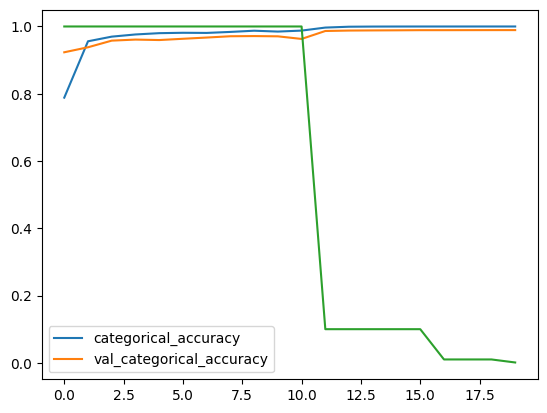

In [134]:
his_df = pd.DataFrame(his.history)
his_df[['categorical_accuracy', 'val_categorical_accuracy']].plot()
(his_df['lr']*1000).plot()

In [135]:
model.evaluate(test_x_data, test_y_data)

1296/1296 [==============================] - 2s 2ms/step - loss: 0.5960 - categorical_accuracy: 0.9040


[0.5960127711296082, 0.904025673866272]

In [136]:
y_pred = model.predict(test_x_data).argmax(axis=1)
len(y_pred), len(test_classes)

1296/1296 [==============================] - 2s 1ms/step


(41459, 41459)

In [137]:
mat = np.zeros(shape=(num_letters,num_letters))
for i in range(len(y_pred)):
    true_ind = test_classes[i]
    pred_ind = y_pred[i]    
    mat[true_ind, pred_ind]+=1

mat=mat/mat.sum(axis=0)
mat

array([[8.24894515e-01, 9.27487352e-03, 1.14285714e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.38396624e-03, 9.10623946e-01, 1.14285714e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.38396624e-03, 7.58853288e-03, 8.90285714e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        9.23937360e-01, 2.81469898e-02, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.79642058e-02, 9.39014855e-01, 7.24637681e-04],
       [0.00000000e+00, 8.43170320e-04, 0.00000000e+00, ...,
        2.46085011e-02, 7.81860829e-04, 9.09420290e-01]])

Text(0, 0.5, 'Predicted letters')

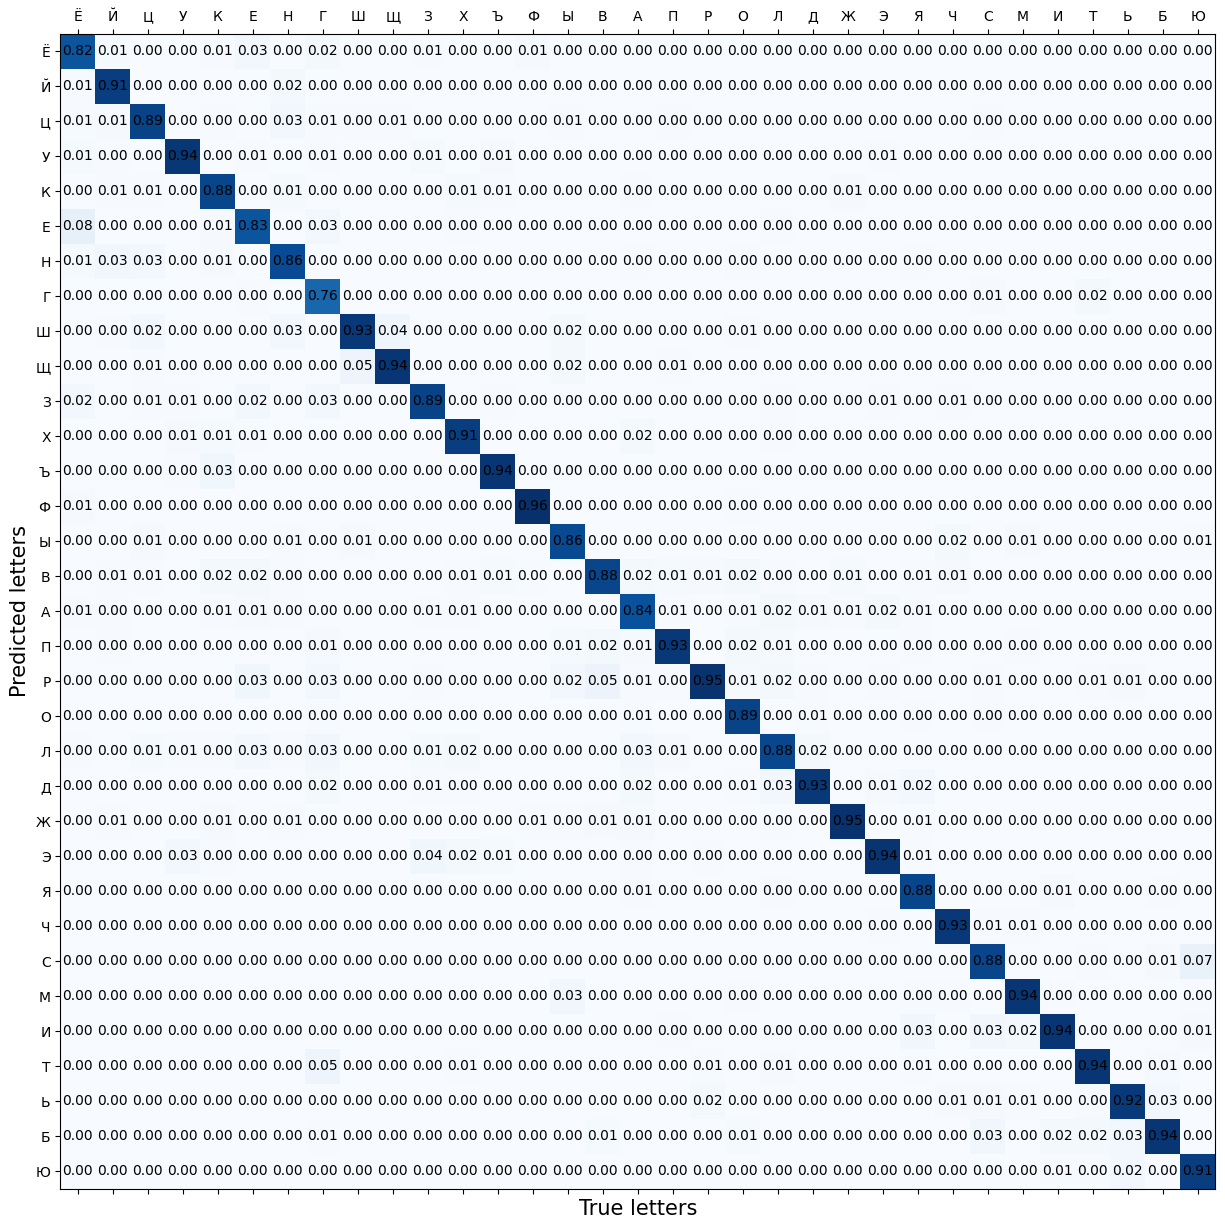

In [138]:
fig, ax = plt.subplots(figsize=(15,15))
ax.matshow(mat, cmap='Blues')
ax.set_xticks(range(len(captions_base)), captions_base)
ax.set_yticks(range(len(captions_base)), captions_base)
for i in range(len(captions_base)):
    for j in range(len(captions_base)):
        c = mat[j,i]
        ax.text(i, j, f'{c:.2f}', va='center', ha='center')
ax.set_xlabel('True letters', fontsize=15)
ax.set_ylabel('Predicted letters', fontsize=15)

1/1 [==============================] - 0s 13ms/step
Ф Ф


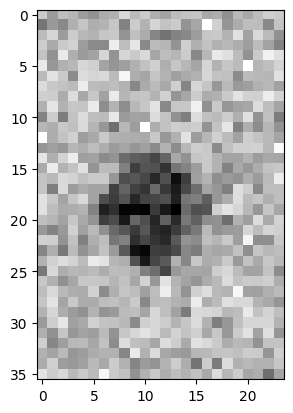

In [155]:
n = 946
img = test_aug.images[n]
print(test_aug.captions[n],captions_base[model.predict(img.reshape((1,*img.shape,1))).argmax()])
plt.imshow(img, cmap='gray')

In [157]:
model.save('models/letter_recognizer.keras')